# Booking a Hotel: a battle of wits

It was not a long time ago when both consumers and sellers of goods and services in virtually every industry were at the mercy of *agents*, a now almost extinct species. Most business models relied on them, as intermediaries and distributors were an essential connecting mechanism in the market place. People bought meat from the butchers, financial services from their bank branch or broker, and flight tickets from the travel agent. 

These agents were instrumental in the setting of prices and discounts, reaching to the right demographic for the products, and for that they received a good chunk of money. The advent of the internet removed many barriers between consumers and sellers of goods and services, and these agents are now unnecessary in most industries.

Their disappearance leaves a big gap between the prices consumers were willing to pay, and revenue that producers obtained. This money is up for grabs, and both consumers and sellers have had to up their game in order to respectively maximize their revenue and minimize the price they paid. The online marketplace have increase exponentially the choices available to buy and sell, and as a result it is extremely competitive.

It is not surpricing then, that a great deal of thought goes behind every online transaction. The hospitality industry is no exception. Sellers have learnt about yield management and dynamic pricing, allowing them to collect more money per room per night. Buyers have more flexibility and a large array of choice when booking, allowing them to compare prices between different channels, and cancel bookings accordingly.


## Objectives

Without taking any sides, the analysis will try to answer questions of relevance to a hotel manager as well as to potential traveller:

* How does hotel pricing vary over time? 
* How far in advance should we book? 
* How reliable are those bookings? Are cancellations easily predictable?


This analysis relies on a Hotel booking demand dataset, available from Kaggle: https://www.kaggle.com/jessemostipak/hotel-booking-demand



## The data

We will import the dataset, find and fix any basic data quality issues (null values, wrong types), and prepare our data to facilitate additional exploration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
 
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# Import data set - assumes data file is on same location as this notebook.
# pd.read_csv dtype option is used to correct some import data types (preventing Numeric IDs being imported as numbers)
df = pd.read_csv('hotel_bookings.csv', dtype = {'agent': str, 'company': str})

In [3]:
# List which features have NaN values: 
df.isnull().mean()[df.isnull().mean() > 0]

children    0.000034
country     0.004087
agent       0.136862
company     0.943069
dtype: float64

In [4]:
# 'company' has 94.3% NaN and is essentially useless, so we will drop it:
# Drop columns with large % of NaN: this will deal with 'company' only, as shown above
df = df.loc[:, df.isnull().mean() <= .75]

In [5]:
# Look at whether there is a likely value for the 'children' NaN values:
df['children'].value_counts()/df.shape[0]

0.0     0.928017
1.0     0.040715
2.0     0.030589
3.0     0.000637
10.0    0.000008
Name: children, dtype: float64

In [6]:
# We also fix the 'children' NaNs with a 0 (the most likely value), and set the type to int
df['children'].fillna(0, inplace = True)
df['children'] = df['children'].astype(np.int64)

In [7]:
# have a look at all the columns, to double check contents, types and any needed modification for readability
# first 15 cols
df.iloc[100:105, :15]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment
100,Resort Hotel,0,4,2015,July,27,4,2,1,2,0,0,BB,ESP,Direct
101,Resort Hotel,0,98,2015,July,27,4,2,1,2,0,0,BB,FRA,Offline TA/TO
102,Resort Hotel,0,92,2015,July,27,4,2,4,1,2,0,BB,FRA,Offline TA/TO
103,Resort Hotel,0,95,2015,July,27,4,2,4,2,0,0,BB,PRT,Online TA
104,Resort Hotel,0,102,2015,July,27,4,2,5,2,0,0,BB,PRT,Online TA


In [8]:
# remaining cols
df.iloc[100:105, 15:]

,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
100,Direct,0,0,0,A,C,0,No Deposit,250,0,Transient,92.67,0,1,Check-Out,2015-07-07
101,TA/TO,0,0,0,D,D,0,No Deposit,8,0,Transient,71.55,1,0,Check-Out,2015-07-07
102,TA/TO,0,0,0,F,F,0,No Deposit,241,0,Transient,96.49,0,2,Check-Out,2015-07-10
103,TA/TO,0,0,0,A,C,0,No Deposit,240,0,Transient,85.80,1,2,Check-Out,2015-07-10
104,TA/TO,0,0,0,E,E,0,No Deposit,240,0,Transient,96.30,0,1,Check-Out,2015-07-11


In [9]:
# Have a look at numeric columns, in particular variability
df.describe()


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [10]:
# Show categorical feature with very large number of categories
for col in df.select_dtypes(include='object').columns.tolist():
    print(col, " : ", df.dtypes[col], " :", len(df[col].value_counts()))

hotel  :  object  : 2
arrival_date_month  :  object  : 12
meal  :  object  : 5
country  :  object  : 177
market_segment  :  object  : 8
distribution_channel  :  object  : 5
reserved_room_type  :  object  : 10
assigned_room_type  :  object  : 12
deposit_type  :  object  : 3
agent  :  object  : 333
customer_type  :  object  : 4
reservation_status  :  object  : 3
reservation_status_date  :  object  : 926


From a preliminary view at data quality, there aren't any more immediate issues to fix. A few things to note though:

* There aren't any columns with a constant value that we might discard. There are however columns with a very large number of categorical values (```reservation_status_date``` and ```agent```) which we might want to remove prior to any ML step. The ```agent``` column also contains a substantial number of NaNs. 
* There are some NaN values left in the ```Country``` column that we will have to deal with prior to any ML step.
* There are a number of 'outliers': bookings with a number of adults/babies/children/nights well beyond 6 stdevs. However in closer inspection at those records, they don't look like an isolated data entry errors (although they are cancelled much more often than usual, some of them were completed correctly).



In [11]:
# Some additional columns for Legends etc:
df['Booking Outcome'] = df['is_canceled'].replace({1: 'canceled', 0: 'not canceled'})

# Exploratory Analysis

### Hotel Pricing and Seasonality

How does hotel pricing vary over time? In other words, when is the optimal time to travel? And, what is the penalty to pay if we must travel at the worst possible time?

In [12]:
df.groupby(['hotel', 'assigned_room_type']).count()[['adr']]

adr
hotel        assigned_room_type       
City Hotel   A                   57007
             B                    2004
             C                     161
             D                   14983
             E                    2168
             F                    2018
             G                     700
             K                     279
             P                      10
Resort Hotel A                   17046
             B                     159
             C                    2214
             D                   10339
             E                    5638
             F                    1733
             G                    1853
             H                     712
             I                     363
             L                       1
             P                       2

In [13]:
df.groupby(['hotel', 'assigned_room_type']).mean()[['adr']]

adr
hotel        assigned_room_type            
City Hotel   A                    96.655321
             B                    93.871163
             C                   100.501925
             D                   121.655856
             E                   143.944862
             F                   178.651526
             G                   184.473986
             K                    53.698889
             P                     0.000000
Resort Hotel A                    81.393893
             B                   101.749119
             C                   114.363234
             D                    86.872154
             E                   107.613819
             F                   120.727265
             G                   159.751802
             H                   171.380772
             I                    40.843774
             L                     8.000000
             P                     0.000000

Based on the above tables, it looks like room types K, P (for city hotels) and I/L/P (for resort hotels) are booked rarely and for a much reduced Average Daily Rate. They appear to be discounted rates, which are not likely to be widely available so we will exclude from the graph.

We can also see that the *Assigned Room Type* is a fundamental factor to the Daily Rate paid per room, with a ~100% difference between the cheapest and most expensive room types, for the same type of hotel.

Additionally, the same room type can cost up to 50% more in a City Hotel than in a Resort hotel. There can be other factors, of course, but will have to segregate these factors when looking at seasonality and price variation. 

In [14]:
df_sub_roomtypes = df[(~df['assigned_room_type'].isin(['K', 'I', 'L', 'P']) )]

In [15]:
df_sub_roomtypes.groupby(['hotel', 'assigned_room_type']).mean()[['adr']]

adr
hotel        assigned_room_type            
City Hotel   A                    96.655321
             B                    93.871163
             C                   100.501925
             D                   121.655856
             E                   143.944862
             F                   178.651526
             G                   184.473986
Resort Hotel A                    81.393893
             B                   101.749119
             C                   114.363234
             D                    86.872154
             E                   107.613819
             F                   120.727265
             G                   159.751802
             H                   171.380772

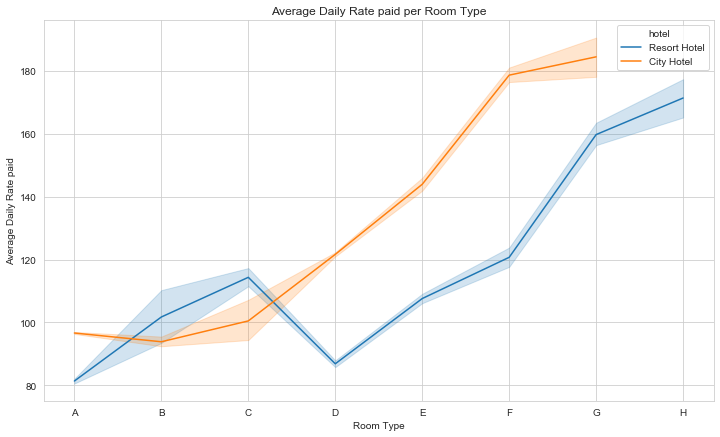

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = sns.lineplot(data = df_sub_roomtypes, x = 'assigned_room_type', hue = 'hotel', y = 'adr')\
            .set(title='Average Daily Rate paid per Room Type', xlabel='Room Type', ylabel='Average Daily Rate paid')


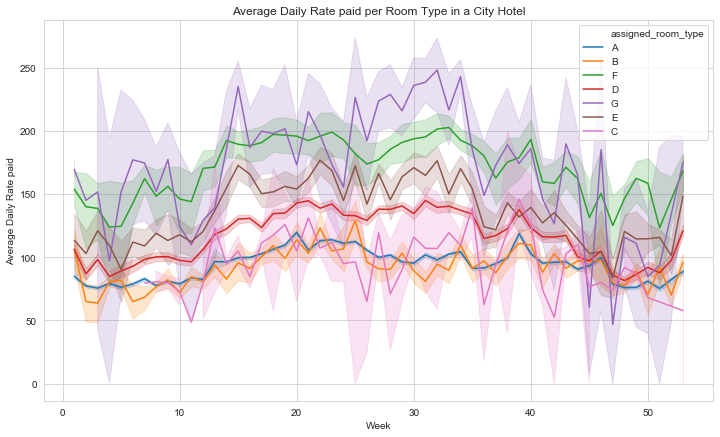

In [17]:
# So, how do these average daily rates vary throughout the year? 

# For a CITY HOTEL:
ax = sns.lineplot(data = df_sub_roomtypes[df_sub_roomtypes.hotel=='City Hotel'], x = 'arrival_date_week_number', hue = 'assigned_room_type', y = 'adr')\
            .set(title='Average Daily Rate paid per Room Type in a City Hotel', xlabel='Week', ylabel='Average Daily Rate paid')


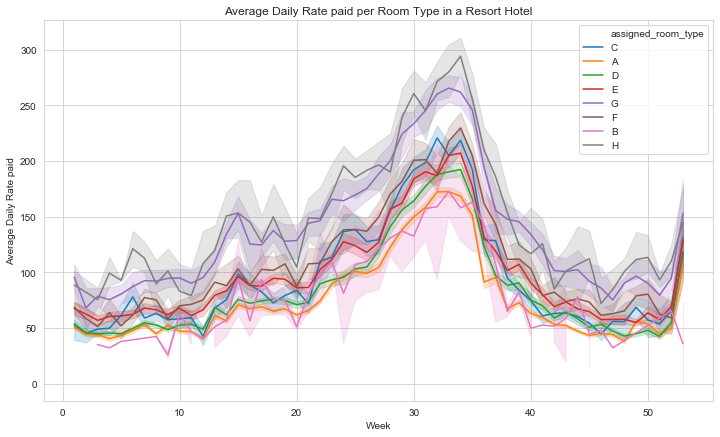

In [18]:
# For a RESORT HOTEL:
ax = sns.lineplot(data = df_sub_roomtypes[df_sub_roomtypes.hotel=='Resort Hotel'], x = 'arrival_date_week_number', hue = 'assigned_room_type', y = 'adr')\
            .set(title='Average Daily Rate paid per Room Type in a Resort Hotel', xlabel='Week', ylabel='Average Daily Rate paid')


Based on the data, we can infer that:

* In a City Hotel, variability throughout the year is small. The cheaper room types do not vary at all, and it is only the most expensive room types which show some price increases throughout weeks 15-35 (May to September).
* In a Resort Hotel, variability is extreme. The same room type can cost $50-$100 in January or $175-$300 in August. 

This is generally expected, as resorts tend to be in locations which attract holiday visitors, and the biggest holiday season is July/August, when most hotels will be running at full capacity, and demand for rooms is higher than supply. In winter, demand is lower than supply, and the prices reflect that. There are minor pricing peaks during other holiday seasons (Easter and Christmas).

In a city hotel, the stream of visitors are not so dependent of holiday seasons, as there will be a mixture of business and leisure travellers. In addition, cities tend to have a larger number of hotels so competition can be high, and that keeps a lid on prices.



### Booking in advance

So, the price varies over time in resort hotels, but much less so in city hotels. A traveller can use that in their favour to obtain a better price, by booking a resort hotel in the less popular periods.

Is there anything else they can do to obtain a better price? How about making a booking in advance? **How sensitive is the price paid to booking in advance?**

In order to assess this, we are going to look at the most popular room type (which is type "A" for both types of hotel, City and Resort - this is also one of the cheapest room types). 



In [19]:
df_sub_advance_bookings = df[(df['assigned_room_type'].isin(['A']) )][['hotel', 'assigned_room_type', 'lead_time', 'adr']]

plt.rcParams['figure.figsize'] = [12, 7]
g = sns.FacetGrid(df_sub_advance_bookings, col = 'hotel', hue='hotel', height = 7, aspect = 1)
plot = g.map(sns.scatterplot, 'lead_time', 'adr', s=100, alpha = .2)\
        .set(xlim=(0,600), ylim=(0,300), xlabel = 'Lead Time (days)', ylabel = 'Daily Rate')


It is evident that **the highest daily rates are associated with shorter lead times**. But it is not so clear-cut: **last minute bookings can also lead to cheaper daily rates**.

What can be clearly ascertained is that, when booking a long time ahead (over 300 days), the rates offered are very predictable. This can be seen both on a City Hotel (the orange dots cluster around 3 clear price levels, possibly peak/off-peak levels), and on a Resort Hotel (the blue dots have a more intense blue, meaning a lot of bookings on the exact same value)

# Predicting Cancellations

The expected likelihood of cancellation varies substantially between a City Hotel (41.7% cancellation rate) and a Resort Hotel (27.7% cancellation rate).

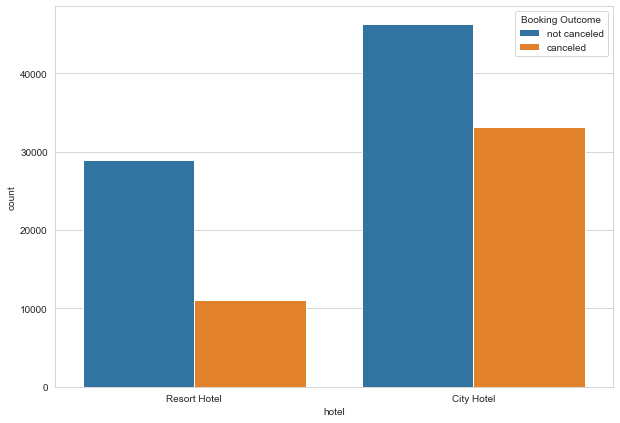

In [20]:
plt.rcParams['figure.figsize'] = [10, 7]
plot = sns.countplot(data = df, x = 'hotel', hue = 'Booking Outcome', palette = 'tab10')

In [21]:
df.groupby(['hotel']).mean()[['is_canceled']]

,is_canceled
hotel,
City Hotel,0.417270
Resort Hotel,0.277634


These are very high cancellation rates! With a 41% chance of cancellation in the City Hotel, it must be quite difficult to manage capacity and ensure that the hotel is neither overbooked nor half empty.

What could a hotel manager do to help? Are these cancellations predictable via a machine learning model?

In [22]:
# A few further preparation before implementing ML model:
# prepare observation matrix X and results vector y
# remove any categorical features with too many categories
# implement dummy columns for remaining categorical features
# prepare training and testing sets

y = df['is_canceled']
X = df.drop('is_canceled', axis = 1)

X.drop(columns = ['reservation_status_date', 'Booking Outcome', 'agent'], inplace = True)  # 'Booking Outcome' was redundant to is_canceled

# Very important to drop reservation_status, as it is correlated with the cancelation!!
X.drop(columns = ['reservation_status'], inplace = True)

categorical_cols = X.select_dtypes(include='object').columns.to_list()

for col in categorical_cols:
    X = pd.concat([ X.drop(col, axis = 1), pd.get_dummies( X[col], prefix = col, drop_first = True, dummy_na = False  ) ] , axis = 1)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)    


In [23]:
# Instantiate model
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000, random_state = 13)
# Fit model to train data
lr.fit(X_train, y_train)
# Predict values for test set
y_preds = lr.predict(X_test)

#### Accuracy

The *accuracy* is defined as the % of cases which were predicted successfully (regardless of whether it was a cancellation or a non-cancellation). In the case of a very simple Machine Learning model (Logistic Regression classifier) this accuracy is 81%. 

No doubt this could be improved by more sophisticated models, but it certainly is a good starting point to prove that these cancellations are largely predictable.

In [24]:
# Score model
print('Accuracy score of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_preds)))

Accuracy score of logistic regression classifier on test set: 0.81


[[13567  1367]
 [ 3107  5837]]


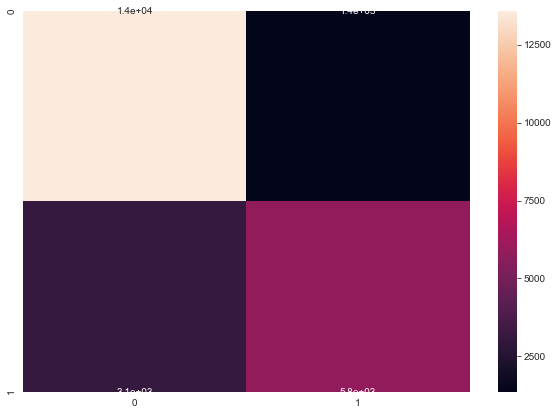

In [25]:
cm = confusion_matrix(y_test, y_preds)
print(cm)
ax = sns.heatmap(cm, annot=True)


#### Classification Report

A better measure of the performance of the ML model is the classification report. This deals separately with positive and negative predictions, as well as the issue of false positives and false negatives (i.e. wrongly predicting a cancellation, and vice-versa).

This report has a specific terminology that we need to define. Each term is applicable to the two classes of events (positive and negative, or in this case, cancellations vs. non-cancellations).
* **Precision**: how many events were correctly classified?
* **Recall**: how many events were found, over the whole number of events?

The reason for these two distinct metrics is that there are cases where the impact of a false positive or false negative is disproportionate (if the probability of the two events is very asimetric), so it is useful to keep track of the four cases separately.

The precision for both classes (cancellations and non-cancellations) is again 81%. 
The recall is a bit less balanced: 91% of actual non-cancellations were correctly predicted as such, but only 65% of actual cancellations were recalled.

I would say that this is still pretty good as a starting point. More complex models can increase overall accuracy, and depending on what use case the business owner wants to implement, the models can be tweaked to minimize false positives or false negatives.

In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     14934
           1       0.81      0.65      0.72      8944

    accuracy                           0.81     23878
   macro avg       0.81      0.78      0.79     23878
weighted avg       0.81      0.81      0.81     23878

